<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [285]:
backtest_base = pd.read_csv("/content/alxn_predictions")
backtest_base.drop("ALXN-1", axis = 1, inplace=True)
backtest_base = backtest_base.set_index("date")
backtest_base.head()

,ALXN,pred_title,pred_sent,pred_rf,pred_lr,pred_nn
date,,,,,,
2020-07-14,0.502130,0.480114,0.533971,0.456329,0.480949,0.376648
2020-07-15,0.541071,0.420187,0.509862,0.515445,0.503870,0.391649
2020-07-16,0.515820,0.575016,0.527880,0.515907,0.541972,0.416346
2020-07-17,0.512321,0.575016,0.520358,0.544831,0.517265,0.400517
2020-07-20,0.516885,0.440776,0.541302,0.524583,0.513842,0.398243


In [286]:
for col in backtest_base.columns:
  backtest_base["change_{column}".format(column = col)] = backtest_base[col].diff()
backtest_base.dropna(inplace=True)

In [287]:
def assign_sign(row):    
  if row > 0:
      row = -1
  else:
      row = 1
  return row

In [289]:
for col in backtest_base.columns[6:]:
  backtest_base[col] = backtest_base[col].apply(lambda x: assign_sign(x))

In [291]:
for col in backtest_base.columns[7:]:
  backtest_base["comp_{column}".format(column = col)] = np.where(backtest_base['change_ALXN'] == backtest_base[col], True, False)

In [277]:
for col in backtest_base.columns[12:]:
  print("Accuracy for {column}".format(column = col))
  print("{}%".format(backtest_base[col].value_counts(normalize=True)[1]*100))

Accuracy for comp_change_pred_title
55.208333333333336%
Accuracy for comp_change_pred_sent
54.166666666666664%
Accuracy for comp_change_pred_rf
43.75%
Accuracy for comp_change_pred_lr
43.75%
Accuracy for comp_change_pred_nn
43.75%


In [293]:
for col in backtest_base.columns[7:11]:
  backtest_base[col] = backtest_base[col].shift(-1)
backtest_base.dropna(inplace=True)

In [294]:
# Set the initial capital
initial_capital= float(1000.0)

# Create a DataFrame `positions`
trading = pd.DataFrame(index=backtest_base.index).fillna(0.0)

for col in backtest_base.columns[7:12]:
  trading[col] = backtest_base[col]*backtest_base["ALXN"]*100

In [295]:
trading["buy_n_hold"] = 0
trading["buy_n_hold"] = trading["buy_n_hold"].astype(float)
trading["buy_n_hold"][0] = backtest_base["ALXN"][0]*-100
trading["buy_n_hold"][-1] = backtest_base["ALXN"][-1]*100

In [296]:
diff = pd.DataFrame(index=backtest_base.index).fillna(0.0)
for col in backtest_base.columns[7:12]:
  diff[col] = backtest_base[col].diff()

diff["buy_n_hold"] = 0
diff["buy_n_hold"] = diff["buy_n_hold"].astype(float)
diff["buy_n_hold"][0] = -1
diff["buy_n_hold"][-1] = 1

In [297]:
portfolio = pd.DataFrame(index=trading.columns).fillna(0.0)

holdings = []
for col in trading.columns:  
  holdings.append(trading[col].sum())
portfolio["holdings"] = holdings

cash = []
for col in trading.columns: 
 cash.append(initial_capital - (diff[col].multiply(backtest_base['ALXN'], axis=0)).sum().cumsum())

portfolio["cash"] = cash
portfolio["cash"] = portfolio["cash"].astype(float)

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = (portfolio["total"]/1000)-1
portfolio

,holdings,cash,total,returns
change_pred_title,362.229986,1000.162154,1362.392140,0.362392
change_pred_sent,-15.013670,998.458777,983.445107,-0.016555
change_pred_rf,-681.365977,1000.701552,319.335574,-0.680664
change_pred_lr,273.273504,999.184970,1272.458475,0.272458
change_pred_nn,191.770549,1000.007302,1191.777850,0.191778
buy_n_hold,17.949501,999.820505,1017.770006,0.017770


In [298]:
returns = pd.DataFrame()
for col in trading.columns:
  returns[col] = trading[col].cumsum()

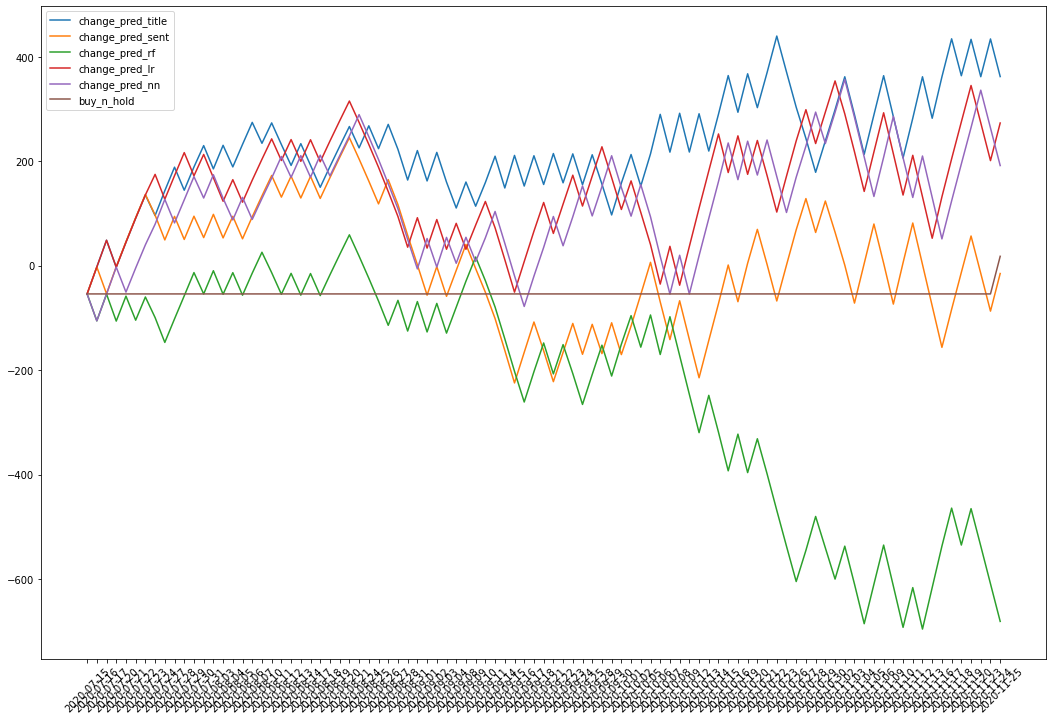

In [299]:
plt.figure(figsize=(18,12))
plt.xticks(rotation=45)
plt.plot(returns)
plt.legend(returns.columns)
plt.show()